In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import scipy
import random
from decimal import Decimal

#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [8]:
TotalFrame.columns.to_list()

['Euler_angles_X',
 'Euler_angles_Y',
 'Euler_angles_Z',
 'Width_Rotation_Angle',
 'Cell_Centroid_X',
 'Cell_Centroid_Y',
 'Cell_Centroid_Z',
 'Cell_Volume',
 'Cell_Volume_Front',
 'Cell_SurfaceArea',
 'Cell_MajorAxis',
 'Cell_MajorAxis_Vec_X',
 'Cell_MajorAxis_Vec_Y',
 'Cell_MajorAxis_Vec_Z',
 'Cell_MinorAxis',
 'Cell_MinorAxis_Vec_X',
 'Cell_MinorAxis_Vec_Y',
 'Cell_MinorAxis_Vec_Z',
 'Cell_MiniAxis',
 'Cell_MiniAxis_Vec_X',
 'Cell_MiniAxis_Vec_Y',
 'Cell_MiniAxis_Vec_Z',
 'OriginaltoReconError',
 'RecontoOriginalError',
 'shcoeffs_L0M0C',
 'shcoeffs_L0M1C',
 'shcoeffs_L0M2C',
 'shcoeffs_L0M3C',
 'shcoeffs_L0M4C',
 'shcoeffs_L0M5C',
 'shcoeffs_L0M6C',
 'shcoeffs_L0M7C',
 'shcoeffs_L0M8C',
 'shcoeffs_L0M9C',
 'shcoeffs_L0M10C',
 'shcoeffs_L1M0C',
 'shcoeffs_L1M1C',
 'shcoeffs_L1M2C',
 'shcoeffs_L1M3C',
 'shcoeffs_L1M4C',
 'shcoeffs_L1M5C',
 'shcoeffs_L1M6C',
 'shcoeffs_L1M7C',
 'shcoeffs_L1M8C',
 'shcoeffs_L1M9C',
 'shcoeffs_L1M10C',
 'shcoeffs_L2M0C',
 'shcoeffs_L2M1C',
 'shcoeffs_L2

Calculated combined PCs and binned PCs


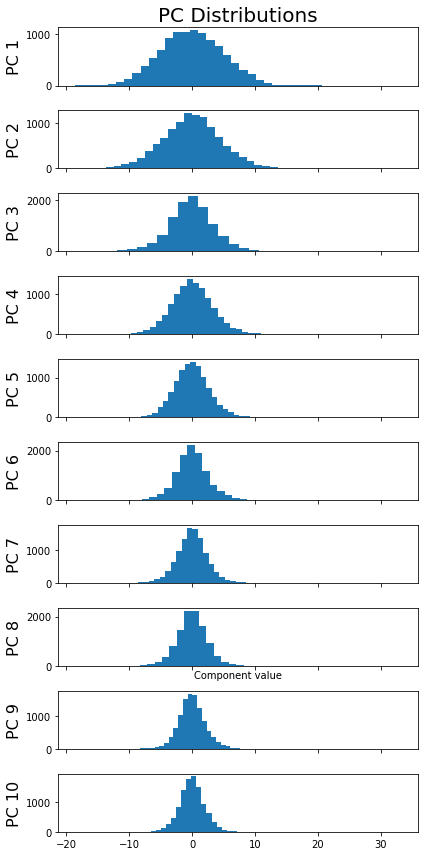

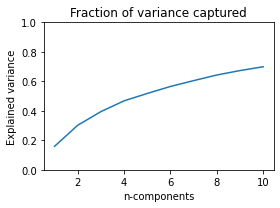

In [10]:
#get directories and open separated datasets

savedir = 'D:/Aaron/Data/Chem_Galv_Combined/Data_and_Figs/'


if os.path.exists(savedir + 'Shape_Metrics_transitionPCbins.csv'):
    
    TotalFrame = pd.read_csv(savedir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)
    print('Opened binned PCs')
    
    #still need to calculate PC bins for later plots
    nbins = 11
    hist1, PC1bins = np.histogram(TotalFrame.PC1, nbins)
    hist2, PC2bins = np.histogram(TotalFrame.PC2, nbins)
    hist3, PC3bins = np.histogram(TotalFrame.PC3, nbins)
    hist4, PC4bins = np.histogram(TotalFrame.PC4, nbins)
    
else:
    from CustomFunctions import shapePCAtools
    from vtk.util import numpy_support
    import vtk
    from aicsshparam import shtools
    import pickle as pk
    
    
    #get directories
    gfl = 'D:/Aaron/Data/Galvanotaxis/'
    gfolder_fl = gfl + 'Data_and_Figs/'

    cfl = 'D:/Aaron/Data/Chemotaxis/'
    cfolder_fl = cfl + 'Data_and_Figs/'
    #open the separate files
    Chem_Shape_Metrics = pd.read_csv(cfolder_fl + 'Shape_Metrics_outliersremoved.csv', index_col=0)
    Galv_Shape_Metrics = pd.read_csv(gfolder_fl + 'Shape_Metrics_outliersremoved.csv', index_col=0)
    
    #combine the two datasets
    TotalFrame = pd.concat([Chem_Shape_Metrics, Galv_Shape_Metrics]).reset_index(drop=True)
    
    #add a column that identifies cells across all frames
    TotalFrame = TotalFrame.rename(columns={"cell.1": "cell"})
    TotalFrame['CellID'] = [x.split('_frame')[0] for x in TotalFrame.cell.to_list()]
    
    #add tags for different experiments
    galvdates = ['20230727',
           '20230801',
           '20230802',
           '20230803']
    exp = []
    for e in TotalFrame.CellID.to_list():
        truth = [True for g in galvdates if g in e]
        if any(truth):
            exp.append('Galv')
        else:
            exp.append('Chem')
    TotalFrame['Experiment'] = exp
    

    ################# Generate new PCs ##############
    from sklearn.decomposition import PCA

    #specify number of PCs and number of bins
    npcs = 10
    nbins = 5
    bins = list(range(1,nbins+1))
    lmax = 10


    shcoeffs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'shcoeffs' in x]].reset_index(drop=True)

    # Fit and transform the data
    pca = PCA(n_components=npcs)
    pca = pca.fit(shcoeffs)
    matrix_of_features_transform = pca.transform(shcoeffs)

    # Dataframe of transformed variable
    pc_names = [f"PC{c}" for c in range(1, 1 + npcs)]
    df_trans = pd.DataFrame(data=matrix_of_features_transform, columns=pc_names, index = TotalFrame.index)
    #drop the previous PCs and 
    TotalFrame = TotalFrame.merge(df_trans, left_index = True, right_index = True)

    # Adjust the sign of PCs so that larger cells are represent by positive values
    for pcid, pc_name in enumerate(pc_names):
        pearson = np.corrcoef(TotalFrame.Cell_Volume.values, TotalFrame[pc_name].values)
        if pearson[0, 1] < 0:
            TotalFrame[pc_name] *= -1
            pca.components_[pcid] *= -1


    ################ RECONSTRUCT CELLS AT CERTAIN POINTS IN THE "SHAPE SPACE" ##################

    df_dig = pd.DataFrame(index = df_trans.index)
    for count, col in enumerate(df_trans.columns.to_list()):
        df_digit, bin_indexes, (bin_centers, pc_std) = shapePCAtools.digitize_shape_mode(
            df = df_trans,
            feature = col,
            nbins = nbins,
            filter_based_on = df_trans.columns.to_list(),
            filter_extremes_pct = float(1),
            save = None,
            return_freqs_per_structs = False
        )
        #put bin_indexes into a larger list that I can later iterate through
        df_dig = df_dig.merge(df_digit[[col,'bin']], left_index = True, right_index = True)
        df_dig = df_dig.rename(columns={'bin':f'PC{count+1}_bins'})


    mid = math.ceil(nbins/2)
    recon_PCs = np.zeros((npcs, nbins, npcs))
    for pi, p in enumerate(pc_names):
        for c in range(nbins):
            for ni, n in enumerate(pc_names):
                if n == p:
                    recon_PCs[pi,c,ni] = df_dig[df_dig[f'PC{ni+1}_bins']==c+1].loc[:,n].mean()
                else:
                    recon_PCs[pi,c,ni] = df_dig[df_dig[f'PC{ni+1}_bins']==mid].loc[:,n].mean()

    #get inverse pca transform of those values
    recon_schoeffs = np.zeros((npcs, nbins, len(shcoeffs.columns)))
    for o in range(recon_schoeffs.shape[0]):
        for t in range(recon_schoeffs.shape[1]):
                recon_schoeffs[o,t,:] = pca.inverse_transform(recon_PCs[o,t,:])


    #combine metrics and digitized pcs
    df_dig = TotalFrame.merge(df_dig, left_index = True, right_index = True)
    #save
    df_dig.to_csv(savedir+"Shape_Metrics_with_Digitized_PCs.csv")


    ########### GET RECONSTRUCTIONS OF AVERAGE CELLS FROM SHAPE SPACE BINS ##########################

    meshes = {}
    for pi, p in enumerate(pc_names):
        meshes[p] = {}
        for c in range(nbins):
            meshes[p][bins[c]] = {}
            mesh, _ = shtools.get_reconstruction_from_coeffs(recon_schoeffs[pi,c,:].reshape(2,lmax+1,lmax+1))
            meshes[p][bins[c]] = mesh



    ################## save PC meshes ##################
    pcmeshdir = savedir + 'PC_Meshes/'
    if not os.path.exists(pcmeshdir):
        os.makedirs(pcmeshdir)
    for p in list(meshes):
        for n, b in enumerate(list(meshes[p])):
            writer = vtk.vtkXMLPolyDataWriter()
            writer.SetFileName(pcmeshdir+p+'_'+str(b)+'_'+'.vtp')
            writer.SetInputData(meshes[p][b])
            writer.Write()

    ####### also save the pca object for later use ###########
    pk.dump(pca, open(savedir+"pca.pkl","wb"))


    ########### plot distributions of PCs ###################
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(10, 1, figsize=(6,12), sharex=True)
    for i, ax in enumerate(axes[:]):
        ax.hist(df_trans.iloc[:,i].values, 30)
    # for i, ax in enumerate(axes[:,1]):
    #     ax.hist(nuc_weights[:,i], 30, (-2,2))

    axes[0].set_title("PC Distributions", fontsize = 20)
    # axes[0,1].set_title("Nucleus Distributions", fontsize = 20)
    [ax.set_ylabel("PC %i"%(i+1), fontsize = 16) for i, ax in enumerate(axes[:])];
    axes[7].set_xlabel("Component value")

    plt.tight_layout()
    plt.savefig(savedir + 'PC distributions.png', bbox_inches='tight')



    # How much variance is explained?
    cell_variance = np.cumsum(pca.explained_variance_ratio_)
    component_number = np.arange(len(cell_variance)) + 1

    # Analysis of explained variance
    df_dimred = {}
    loading = pca.components_.T * np.sqrt(pca.explained_variance_)
    for comp, pc_name in enumerate(pc_names):
        load = loading[:, comp]
        pc = [v for v in load]
        apc = [v for v in np.abs(load)]
        total = np.sum(apc)
        cpc = [100 * v / total for v in apc]
        df_dimred[pc_name] = pc
        df_dimred[pc_name.replace("_PC", "_aPC")] = apc
        df_dimred[pc_name.replace("_PC", "_cPC")] = cpc

    # Store results as a dataframe
    df_dimred["features"] = shcoeffs.columns
    df_dimred = pd.DataFrame(df_dimred)
    df_dimred = df_dimred.set_index("features", drop=True)

    # Plot variance
    plt.figure(figsize=(4, 3))
    plt.plot(component_number, cell_variance)
    plt.ylim(0,1)
    plt.xlabel("n-components")
    plt.ylabel("Explained variance")
    plt.title("Fraction of variance captured")

    plt.tight_layout()
    plt.savefig(savedir + 'Variance captured.png', bbox_inches='tight')





    ############## SEE WHICH FEATURES ARE MOST IMPORTANT IN EACH PC #############
    save = savedir + 'Feature_Importance'
    # Log feature importance along each PC
    with open(f"{save}.txt", "w") as flog:

        for comp in range(npcs):

            print(
                f"\nExamplined variance by PC{comp+1} = {100*pca.explained_variance_ratio_[comp]:.1f}%",
                file=flog,
            )

            # Feature importance is reported in 3 ways:
            # _PC - raw loading
            # _aPC - absolute loading
            # _cPC - normalized cummulative loading
            pc_name = pc_names[comp]
            df_sorted = df_dimred.sort_values(
                by=[pc_name.replace("_PC", "_aPC")], ascending=False
            )
            pca_cum_contrib = np.cumsum(
                df_sorted[pc_name.replace("_PC", "_aPC")].values
                / df_sorted[pc_name.replace("_PC", "_aPC")].sum()
            )
            pca_cum_thresh = np.abs(pca_cum_contrib - 0.80).argmin()
            df_sorted = df_sorted.head(n=pca_cum_thresh + 1)

            print(
                df_sorted[
                    [
                        pc_name,
                        pc_name.replace("_PC", "_aPC"),
                        pc_name.replace("_PC", "_cPC"),
                    ]
                ].head(),
                file=flog,
            )


    #get changes in PCs between consecutive frames of a movie
    nbins = 11


    #first bin PCs
    hist1, PC1bins = np.histogram(TotalFrame.PC1, nbins)
    hist2, PC2bins = np.histogram(TotalFrame.PC2, nbins)
    hist3, PC3bins = np.histogram(TotalFrame.PC3, nbins)
    hist4, PC4bins = np.histogram(TotalFrame.PC4, nbins)
    TotalFrame['PC1bins'] = np.digitize(TotalFrame.PC1, PC1bins)
    TotalFrame['PC2bins'] = np.digitize(TotalFrame.PC2, PC2bins)
    TotalFrame['PC3bins'] = np.digitize(TotalFrame.PC3, PC2bins)
    TotalFrame['PC4bins'] = np.digitize(TotalFrame.PC4, PC2bins)

    TotalFrame.to_csv(savedir + 'Shape_Metrics_transitionPCbins.csv')
    print('Calculated combined PCs and binned PCs')

In [5]:
############### Get Correlation matrix #######################

#stats to remove, if any
to_remove = [i for i in TotalFrame.columns.to_list() if 'Axis' in i] 
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Centroid' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'intensity' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'shcoeff' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Trajectory' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'dist' in i])


#get pearson correlation matrix for TotalFrame without bins
totalcorr = TotalFrame.drop(columns = to_remove)
totalcorr = totalcorr.corr()


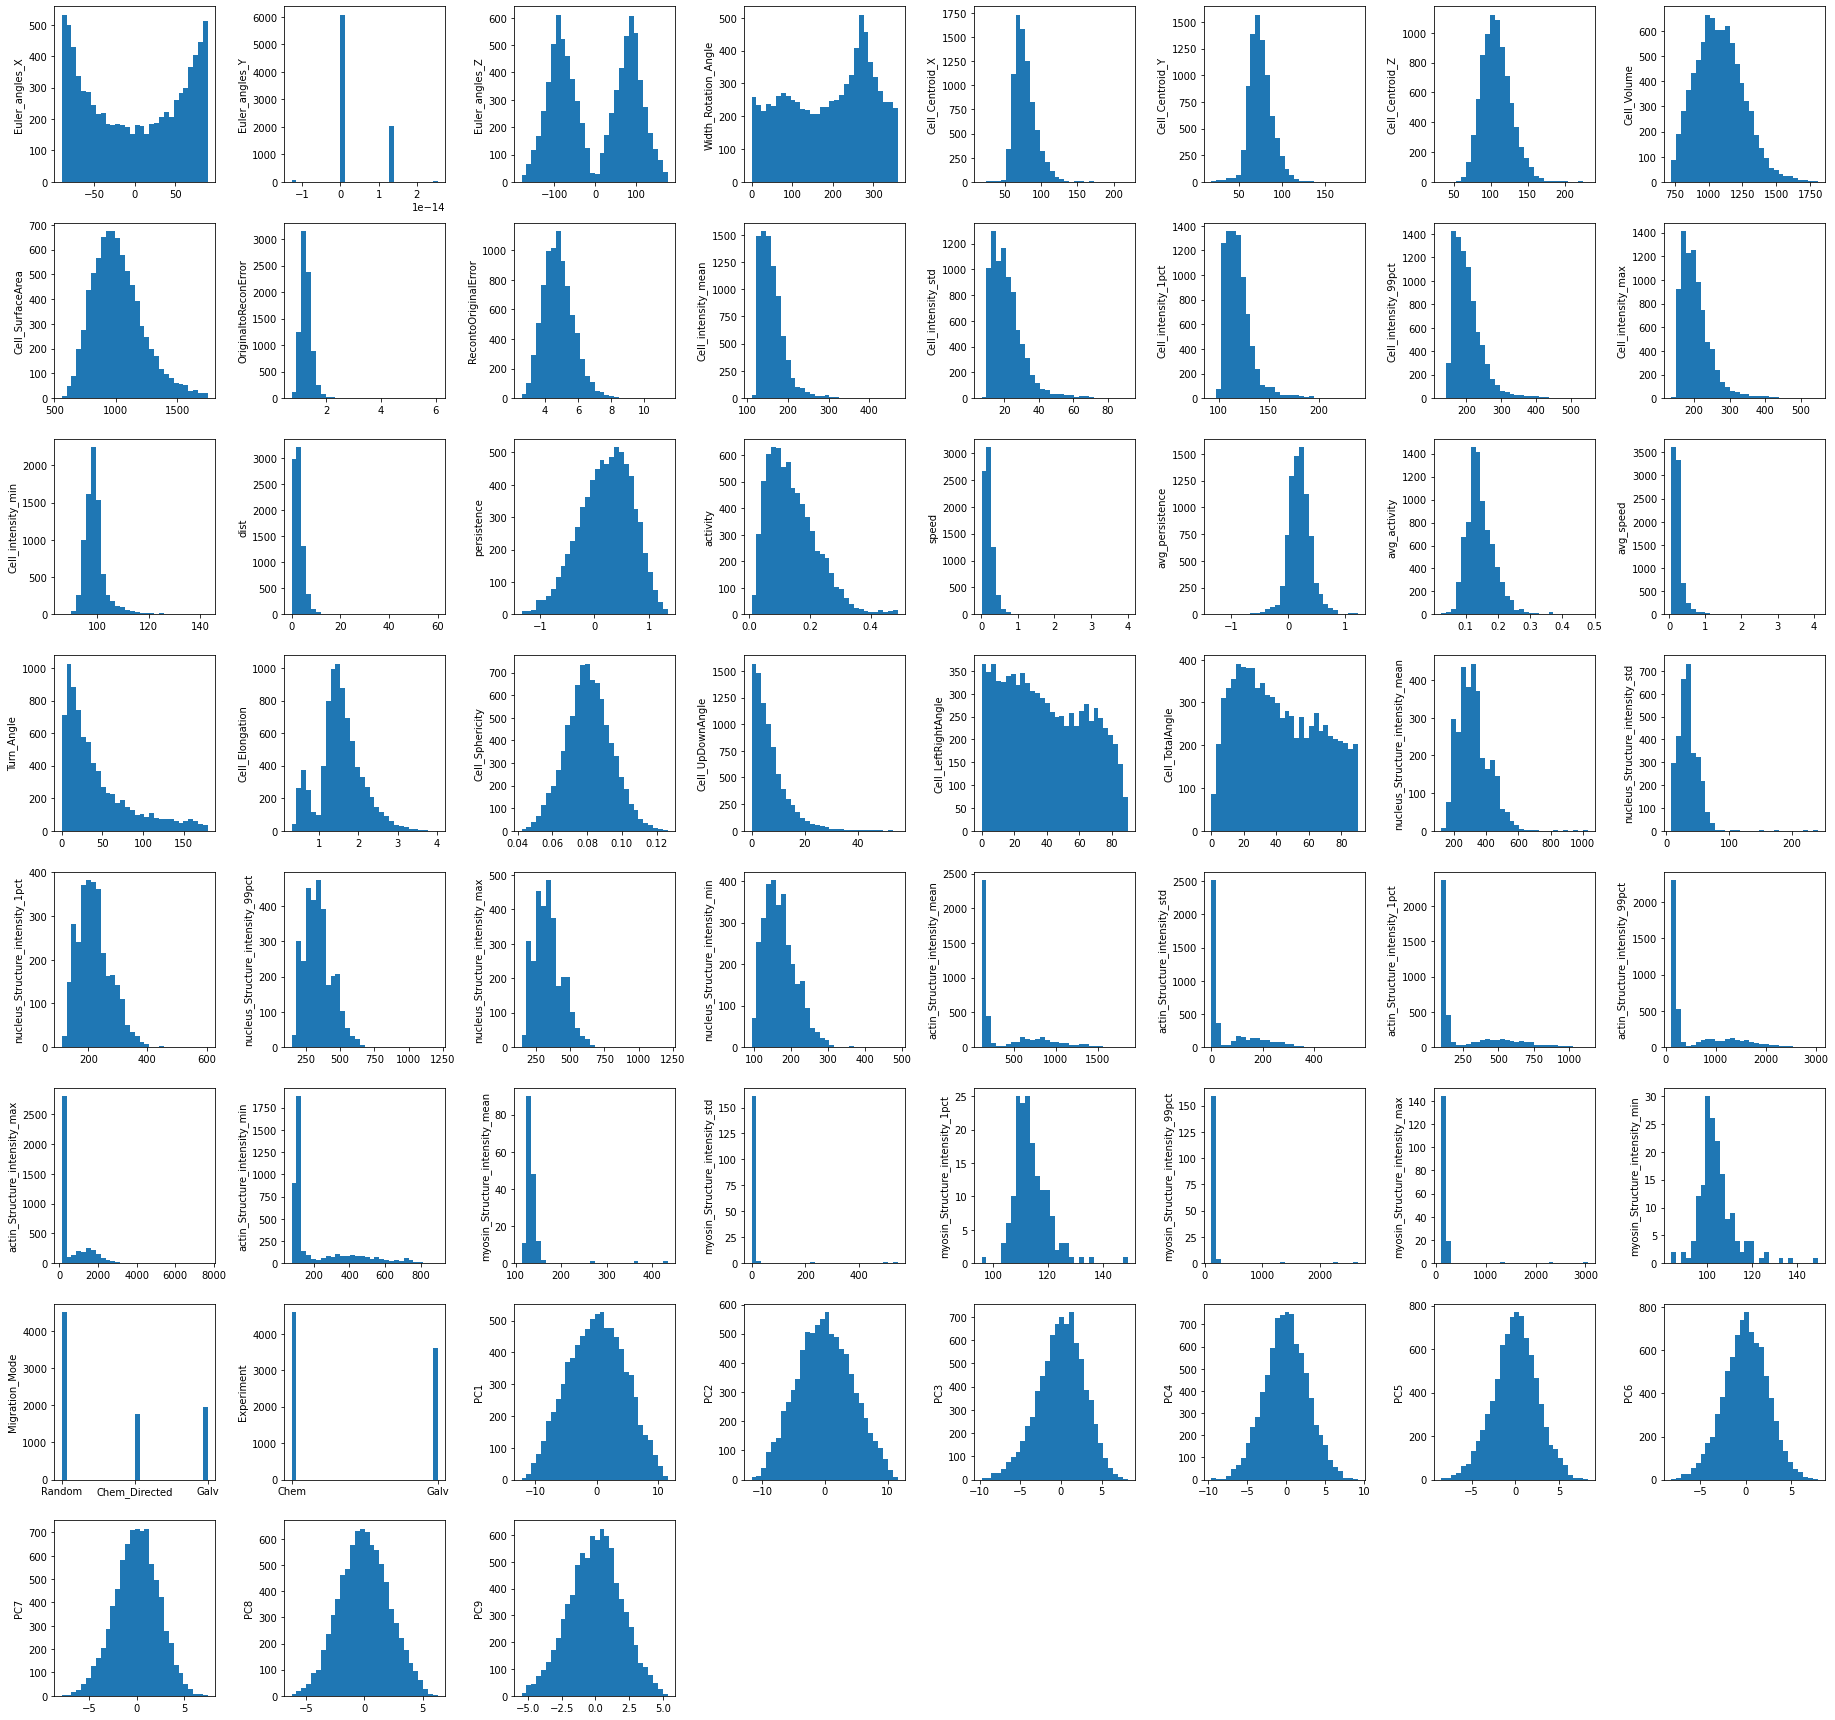

In [36]:
################# LOOK AT STAT DISTRIBUTIONS ######################


# colors = list(sns.color_palette('deep').as_hex())
smallerframe = TotalFrame.drop(columns = to_remove)
smallerframe = smallerframe.drop(columns = ['cell','cell.1','CellID','structure','frame'])
CoRo = math.ceil(math.sqrt(len(smallerframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(smallerframe.columns.to_list()):
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    ax.hist(smallerframe.iloc[:,i], 30)#, color=colors[i]) , 30, (-2,2))
    ax.set_ylabel(smallerframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1

        
#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];

plt.tight_layout()
# plt.savefig(folder_fl + 'Shape Metric Histograms.png', bbox_inches='tight')

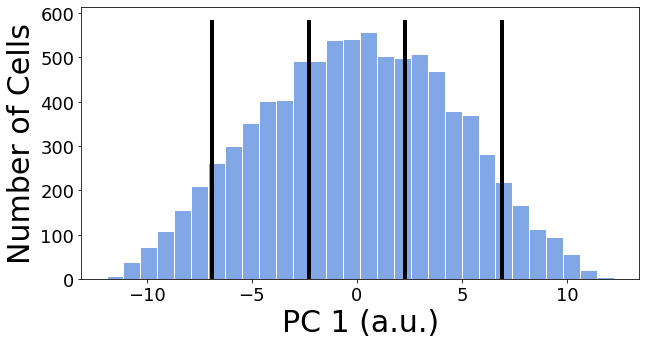

In [108]:
####################### plot distribution of PC1 with Std lines ######################
plt.figure(figsize=(10,5))
dat = TotalFrame.PC1.copy()
plt.hist(dat, color = '#81a7e6',bins=30, edgecolor='white')
plt.ylabel('Number of Cells', fontsize = 30)
plt.xlabel('PC 1 (a.u.)', fontsize = 30)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
ylim = plt.axis()[3]
st = dat.std()
plt.vlines([-((st/2)+st),-st/2, st/2, (st/2)+st], 0, ylim, lw=4, color = 'black')
# plt.vlines(-dat.std(), 0, ylim)
plt.savefig(savedir+ 'PC1 distribution.png', bbox_inches='tight')

In [ ]:
################ how much is rotation of the cell changing from frame to frame ###############



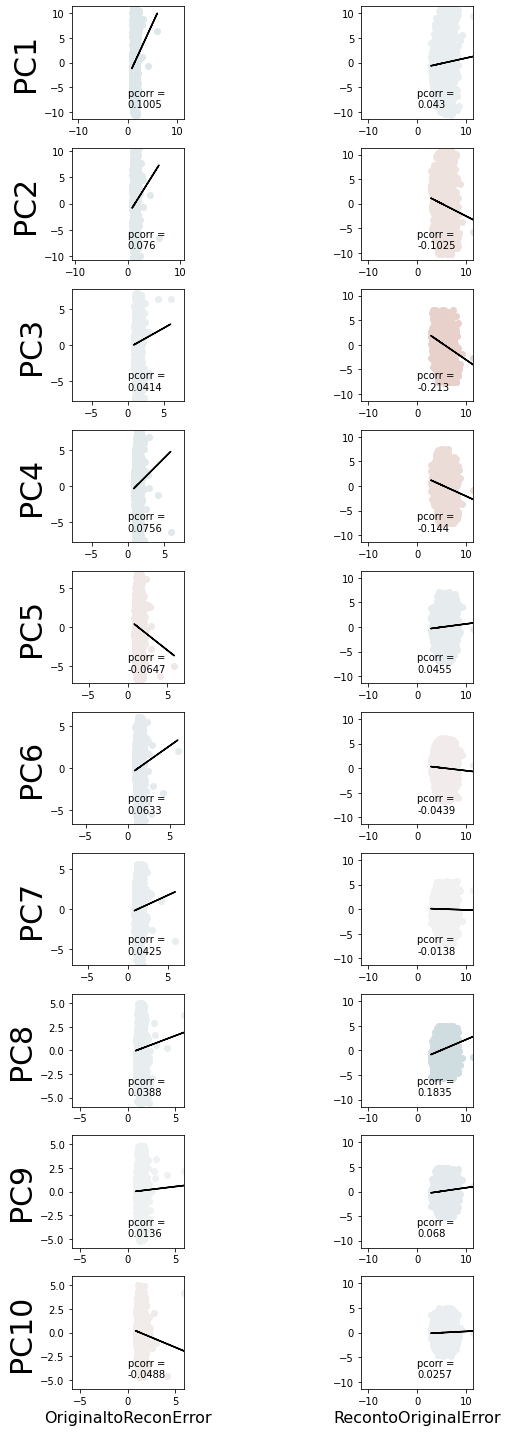

In [22]:
########## correlation between PCs and reconstruction error ###############


color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
metric_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'Error' in x]]
PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'delta' not in x]]

fig, axes = plt.subplots(len(PC_frame.columns), len(metric_frame.columns), figsize=(10,20))#, sharex=True)
for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        x = metric_frame.iloc[:,i]
        y = PC_frame[f'PC{q+1}']
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
        p_corr = totalcorr.loc[f'PC{q+1}', metric_frame.iloc[:,i].name]
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, intercept+slope*x, 'k')
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
        ax.text(0.5, 0.1, 'pcorr =\n'+str(round(p_corr,4)),transform=ax.transAxes)
        ax.set_aspect('equal','box')
        maxlim = max(x.max(),y.max(), abs(x.min()), abs(y.min()))
        ax.set_xlim(-maxlim,maxlim)
        ax.set_ylim(-maxlim,maxlim)

xlabels = [x.replace('_','\n') for x in metric_frame.columns]
[ax.set_ylabel(PC_frame.columns[i], fontsize = 30) for i, ax in enumerate(axes[:,0])];
[ax.set_xlabel(xlabels[i], fontsize = 16) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
# plt.savefig(folder_fl+ 'PC vs. Metric scatter matrix.png', bbox_inches='tight')

In [29]:
############### get list of metrics that are significant by migration mode using anova ############
ModeFrame = TotalFrame.copy()

import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Migration_Mode' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'Cell_Centroid_X', 'Cell_Centroid_Y', 'Cell_Centroid_Z'])
for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    samples = [g[1].dropna() for g in ModeFrame.groupby('Migration_Mode')[c]]
    f_val, p_val = ss.f_oneway(*samples)
    print(f'Name: {c}, F value: {f_val}, p value: {p_val}')
    if p_val < 0.05:
        siglist.append(c) 
siglist = sorted(siglist)
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# for c in siglist:
#     print(f'Name {c}', pairwise_tukeyhsd(GeneFrame[c], GeneFrame['Gene']))

# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']

Name: Cell_Volume, F value: 588.3992011771041, p value: 3.0842322233662746e-240
Name: Cell_SurfaceArea, F value: 311.06472529032817, p value: 3.6858152794371273e-131
Name: persistence, F value: 18.119317949089623, p value: 1.4129506308032542e-08
Name: speed, F value: 80.75753085027489, p value: 1.8888610136891394e-35
Name: Turn_Angle, F value: 17.820279606778694, p value: 1.8963101896217366e-08
Name: Cell_Elongation, F value: 3.4004254769221816, p value: 0.03340390588209696
Name: Cell_Sphericity, F value: 233.09465638634046, p value: 2.6018723484760323e-99
Name: Cell_UpDownAngle, F value: 1.6052215396897405, p value: 0.2009051912037979
Name: Cell_LeftRightAngle, F value: 3.2425280942594443, p value: 0.03911274674630839
Name: Cell_TotalAngle, F value: 3.2515381657785802, p value: 0.03876218433112355
Name: PC1, F value: 3.011241990822324, p value: 0.04928237705098807
Name: PC2, F value: 0.8208692000547008, p value: 0.4400834532155361
Name: PC3, F value: 43.475190960174416, p value: 1.635

IndexError: index 6 is out of bounds for axis 0 with size 6

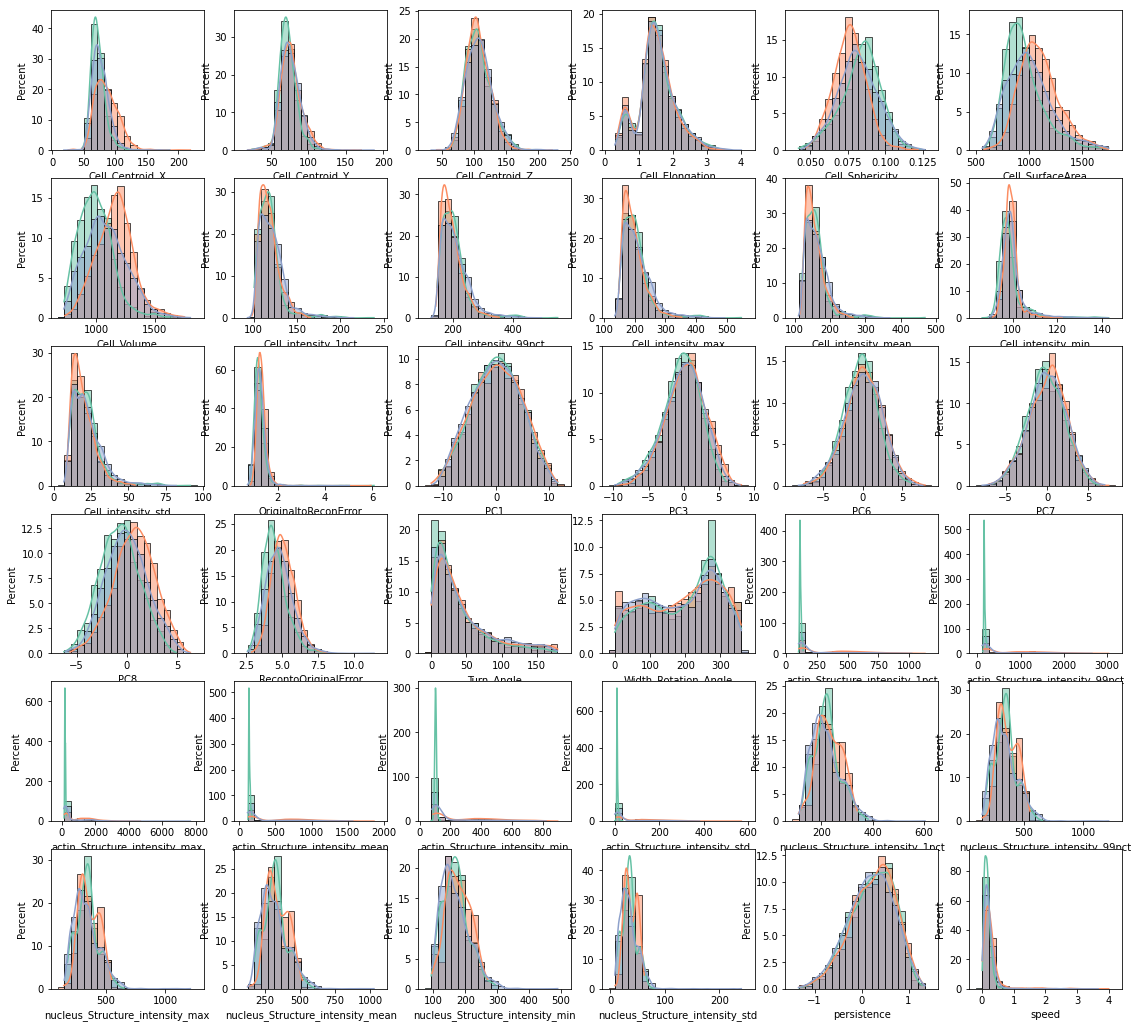

In [44]:
################# LOOK AT STAT DISTRIBUTIONS OF SIGNIFICANT STATS ######################
import seaborn as sns

colors = sns.color_palette("Set2")
colors = list(colors.as_hex())


# colors = list(sns.color_palette('deep').as_hex())
smallerframe = TotalFrame[siglist]
CoRo = math.ceil(math.sqrt(len(smallerframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(smallerframe.columns.to_list()):

    
    #get the metric in question separated by migration mode
    samples = [g[1].dropna() for g in ModeFrame.groupby('Migration_Mode')[met]]
    
        
    #get bins so that the widths between all types are the same
    maxx = max([max(x) for x in samples])
    minn = min([min(x) for x in samples])
    binwidth = (maxx-minn)*0.05
    maxx = maxx + binwidth
    minn = minn - binwidth
    binss = np.linspace(minn,maxx,round((maxx-minn)/binwidth))
    
    #plot the data
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    sns.histplot(ax = ax, data=samples[0], bins=binss, stat='percent', color = colors[0], kde = True)
    sns.histplot(ax = ax, data=samples[1], bins=binss, stat='percent', color = colors[1], kde = True)
    sns.histplot(ax = ax, data=samples[2], bins=binss, stat='percent', color = colors[2], kde = True)
#     ax.set_ylabel(met)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1


ax = axes[row,(i-((CoRo-1)*row)-row)]
fig.legend(ModeFrame.Migration_Mode.unique(), loc = 'lower right')

#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];
# plt.legend(ModeFrame.Migration_Mode.unique(), loc ='lower right')
plt.tight_layout()
plt.savefig(folder_fl + 'Significant Shape Metric Histograms.png', bbox_inches='tight')

In [ ]:
TotalFrame.sort

In [58]:
#get the number of images of cells and unique cells per migration mode
samplesize = pd.DataFrame([])

for m, mod in TotalFrame.groupby('Migration_Mode'):
    imnum = len(mod)
    cellnum = len(mod.CellID.unique())
    samplesize = samplesize.append(pd.DataFrame({'Migration Mode':m.replace('_',' '),
                                                 'Cells':cellnum, 
                                                'Images':imnum}, index = [0]))

samplesize = samplesize.reset_index(drop=True)
samplesize.iloc[0], samplesize.iloc[1], samplesize.iloc[2] = samplesize.iloc[2].copy(), samplesize.iloc[0].copy(), samplesize.iloc[1].copy()
samplesize['Migration Mode'] = ['Random','Chemotaxis','Galvanotaxis']
samplesize

Migration Mode  Cells  Images
0         Random    334    4607
1     Chemotaxis    129    1752
2   Galvanotaxis    183    2249

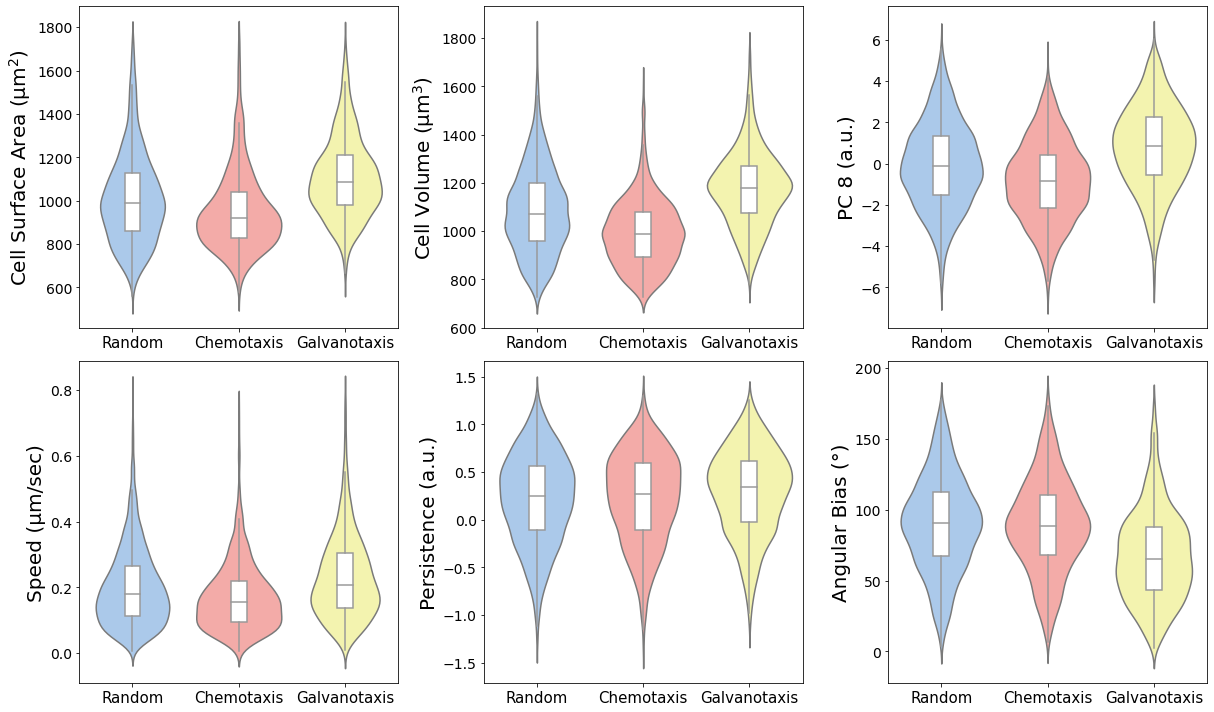

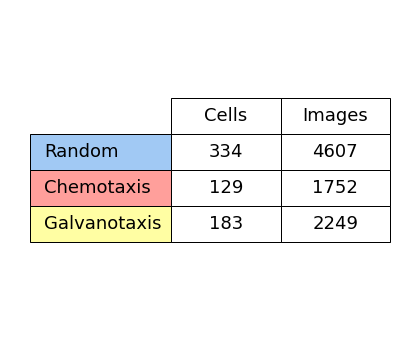

In [59]:
############### Metric distributions by gene #################################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular Bias'] = angles

#### remove speed outliers
tempframe = TotalFrame[TotalFrame.speed<0.8]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['Cell_SurfaceArea','Cell_Volume','PC8','speed','persistence','Angular Bias']
siglabels = ['Cell Surface Area (µm$^2$)','Cell Volume (µm$^3$)','PC 8 (a.u.)','Speed (µm/sec)','Persistence (a.u.)','Angular Bias (°)']


fig, axes = plt.subplots(2, 3, figsize=(17,10))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Migration_Mode'):
for i, sig in enumerate(smallersig):
    vp = sns.violinplot(data=tempframe, x='Migration_Mode', y=sig, palette = colorlist, inner = None, ax=axli[i], )
    bp = sns.boxplot(data=tempframe, x='Migration_Mode', y=sig, width = 0.15, 
            color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    axli[i].set_ylabel(siglabels[i], fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    axli[i].set_xticklabels(samplesize['Migration Mode'].to_list(), fontsize = 15)


plt.tight_layout()
plt.savefig(savedir + 'migration mode significant metric violins.png', bbox_inches='tight')




fig, ax = plt.subplots(1, 1, figsize=(7,6))#, sharex=True)     
tb = ax.table(cellText=samplesize.values[:,1:],
      rowLabels=samplesize.values[:,0],
      rowColours=colorlist,
      colLabels=samplesize.columns[1:].to_list(),
        loc= 'center right',
        cellLoc = 'center',
        colWidths = [0.35]*len(samplesize))
tb.scale(0.8,3)
tb.auto_set_font_size(False)
tb.set_fontsize(18)
ax.axis('off')
plt.savefig(savedir + 'migration mode significant metric table.png', bbox_inches='tight')




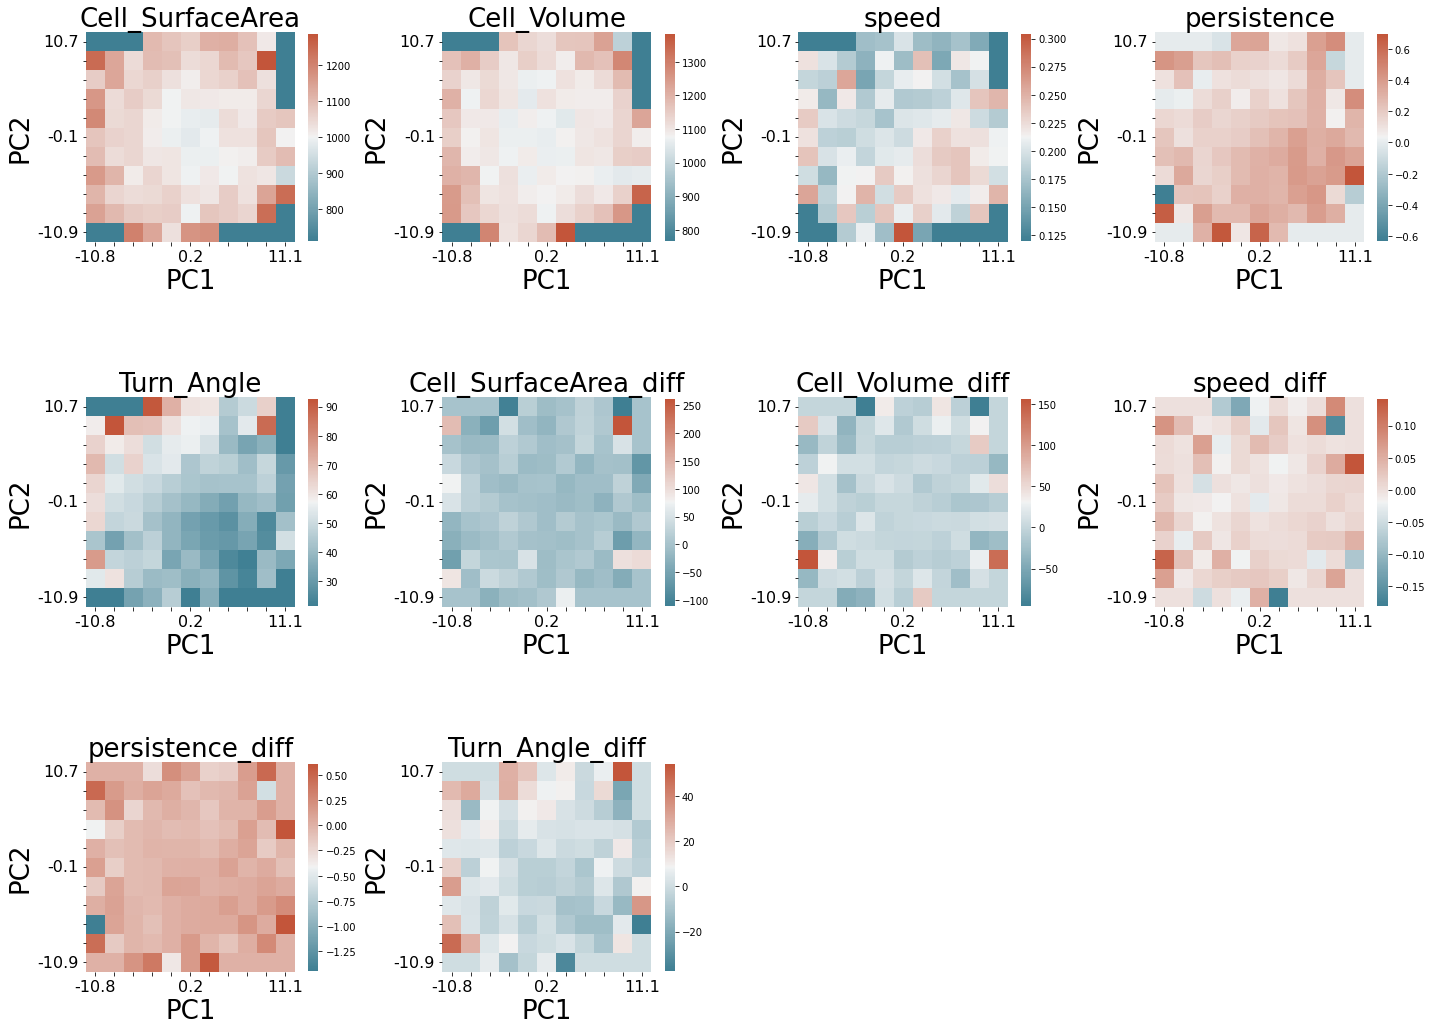

In [26]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

#add some metric differentials
metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle']
TotalFrame = TotalFrame.sort_values(['CellID','frame'])
diffmets = metrics.copy()
for d in metrics:
    TotalFrame[d+'_diff'] = TotalFrame[d].diff()
    diffmets.append(d+'_diff')

#make subplots
sp = math.ceil(math.sqrt(len(diffmets)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(diffmets):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[diffmets[i]]
                else:
                    bighm[y,x] = current[diffmets[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC2', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(diffmets[i], fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight')

In [ ]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRIC DIFFERENTIALS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle']

sp = math.ceil(math.sqrt(len(metrics)))

fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(metrics):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[metrics[i]]
                else:
                    bighm[y,x] = current[metrics[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC2', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(metrics[i], fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator


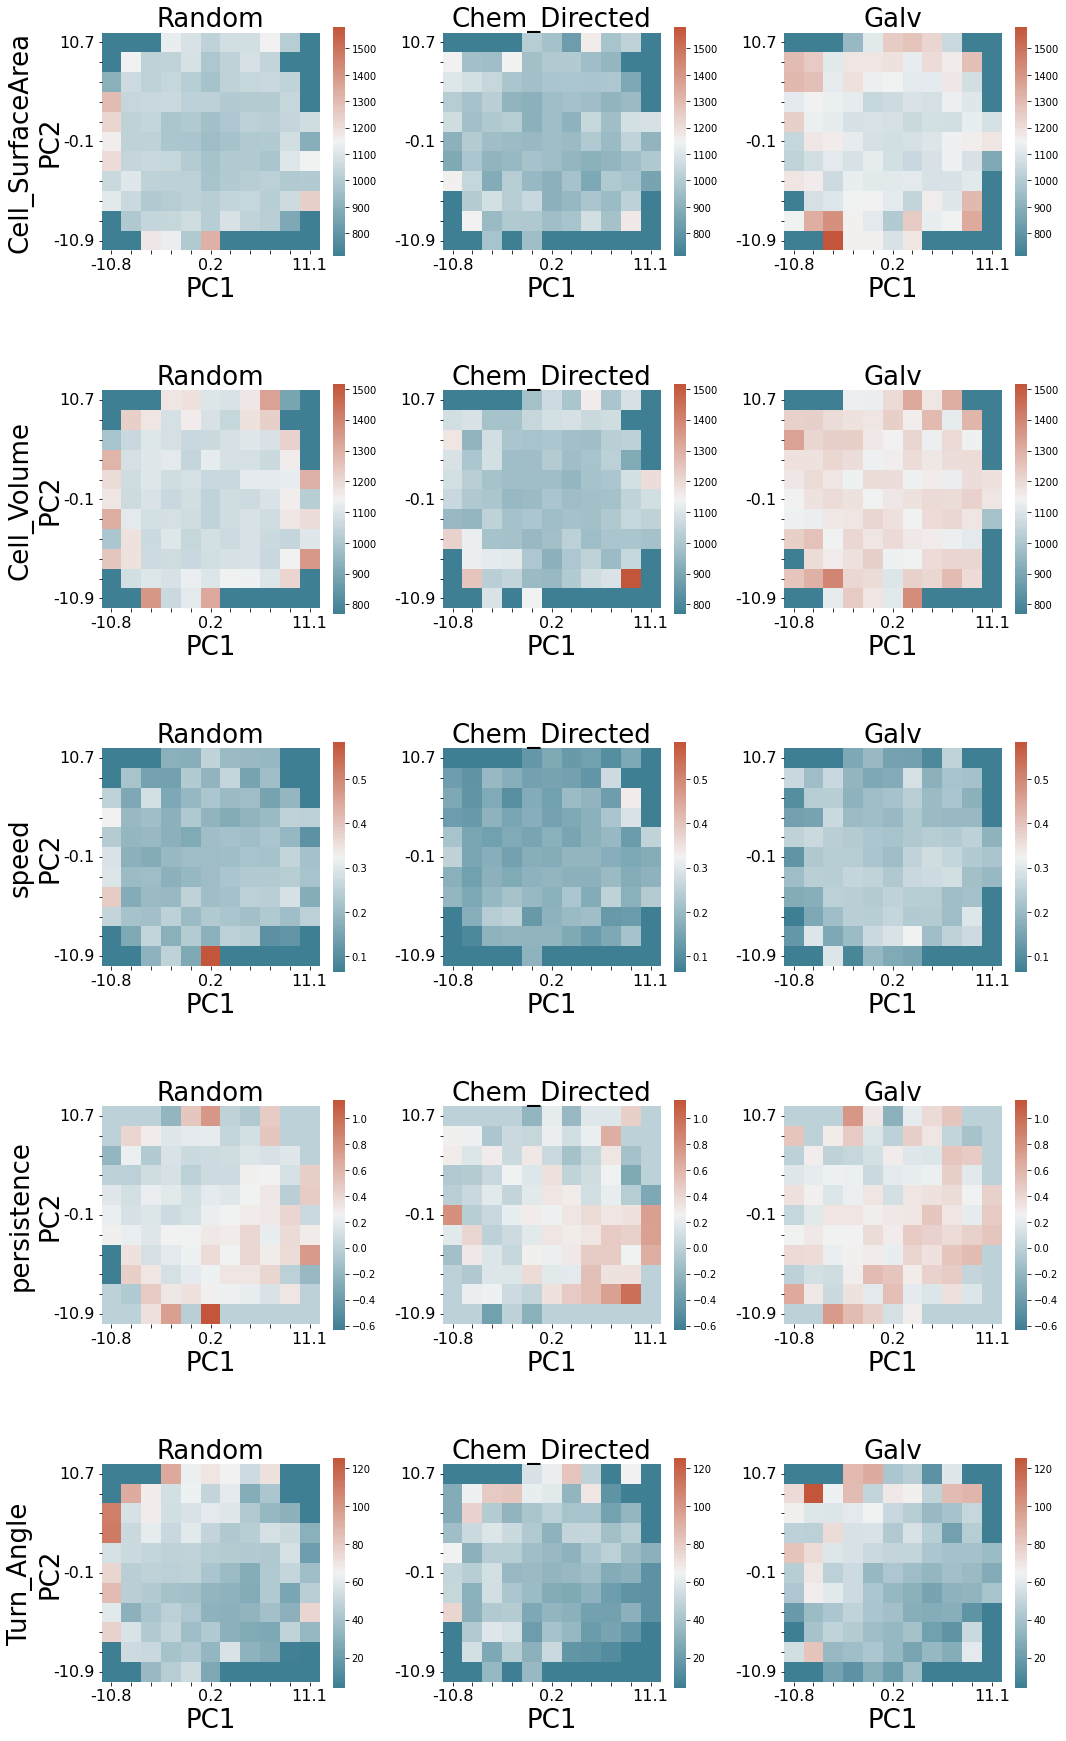

In [181]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle']

sp = math.ceil(math.sqrt(len(metrics)))

fig, axes = plt.subplots(len(metrics),len(TotalFrame.Migration_Mode.unique()),figsize=(15,len(metrics)*5))


for i, met in enumerate(metrics):
    for a, ax in enumerate(axes[i]):
        mm = TotalFrame.Migration_Mode.unique()[a]
        mdf = TotalFrame[TotalFrame.Migration_Mode==mm]
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((len(axes[i]),nbins,nbins))
        for n in range(bighm.shape[0]):
            mdf = TotalFrame[TotalFrame.Migration_Mode==TotalFrame.Migration_Mode.unique()[n]]
            for x in range(nbins):
                for y in range(nbins):
                    current =  mdf[(mdf['PC1bins'] == x+1) & (mdf['PC2bins'] == y+1)].dropna(subset=[met])
                    if current.empty:
                        bighm[n,y,x] = 0
                    elif len(current)==1:
                        bighm[n,y,x] = current[met]
                    else:
                        bighm[n,y,x] = current[met].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm[a,:,:],
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=np.max(bighm), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.75}
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)      
        if (a == 0):
            ax.set_ylabel(f'{met}\nPC2', fontsize = 26, labelpad=-10)
#         else:
#             ax.set_ylabel(f'PC2', fontsize = 26, labelpad=-10)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(mm, fontsize = 26)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps separated.png', bbox_inches='tight')

C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:3621: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


Name Cell_Centroid_X          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj  lower    upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv  13.8299   0.0  12.5991 15.0607   True
Chem_Directed_Chem Random_Chem   2.3165   0.0   1.1808  3.4522   True
Chem_Directed_Chem Random_Galv   6.5544   0.0   5.2757  7.8331   True
         Galv_Galv Random_Chem -11.5134   0.0 -12.6137 -10.413   True
         Galv_Galv Random_Galv  -7.2755   0.0  -8.5229 -6.0281   True
       Random_Chem Random_Galv   4.2379   0.0   3.0842  5.3916   True
---------------------------------------------------------------------
Name Cell_Centroid_Y          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   4.8776    0.0  

Name Cell_intensity_99pct          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv  -6.9099    0.0 -10.4941 -3.3257   True
Chem_Directed_Chem Random_Chem   9.9033    0.0    6.596 13.2106   True
Chem_Directed_Chem Random_Galv  -2.6488 0.2602  -6.3725  1.0749  False
         Galv_Galv Random_Chem  16.8132    0.0  13.6089 20.0175   True
         Galv_Galv Random_Galv   4.2611 0.0138   0.6286  7.8937   True
       Random_Chem Random_Galv -12.5521    0.0 -15.9117 -9.1924   True
----------------------------------------------------------------------
Name Cell_intensity_max          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------
Chem_Directed_Chem   Galv_G

Name PC8          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   1.4552    0.0  1.2838  1.6265   True
Chem_Directed_Chem Random_Chem   0.3745    0.0  0.2164  0.5326   True
Chem_Directed_Chem Random_Galv   1.2123    0.0  1.0343  1.3903   True
         Galv_Galv Random_Chem  -1.0807    0.0 -1.2339 -0.9275   True
         Galv_Galv Random_Galv  -0.2429 0.0019 -0.4165 -0.0692   True
       Random_Chem Random_Galv   0.8378    0.0  0.6772  0.9984   True
---------------------------------------------------------------------
Name PC9          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   0.1491 0.0833 -0.0127  0.3108  False
Ch

Name nucleus_Structure_intensity_1pct       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
      group1          group2   meandiff p-adj lower upper reject
----------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv      nan   nan   nan   nan  False
Chem_Directed_Chem Random_Chem      nan   nan   nan   nan  False
Chem_Directed_Chem Random_Galv      nan   nan   nan   nan  False
         Galv_Galv Random_Chem      nan   nan   nan   nan  False
         Galv_Galv Random_Galv      nan   nan   nan   nan  False
       Random_Chem Random_Galv      nan   nan   nan   nan  False
----------------------------------------------------------------
Name nucleus_Structure_intensity_99pct       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
      group1          group2   meandiff p-adj lower upper reject
----------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv      nan   nan   nan   nan  False
Chem_Directed

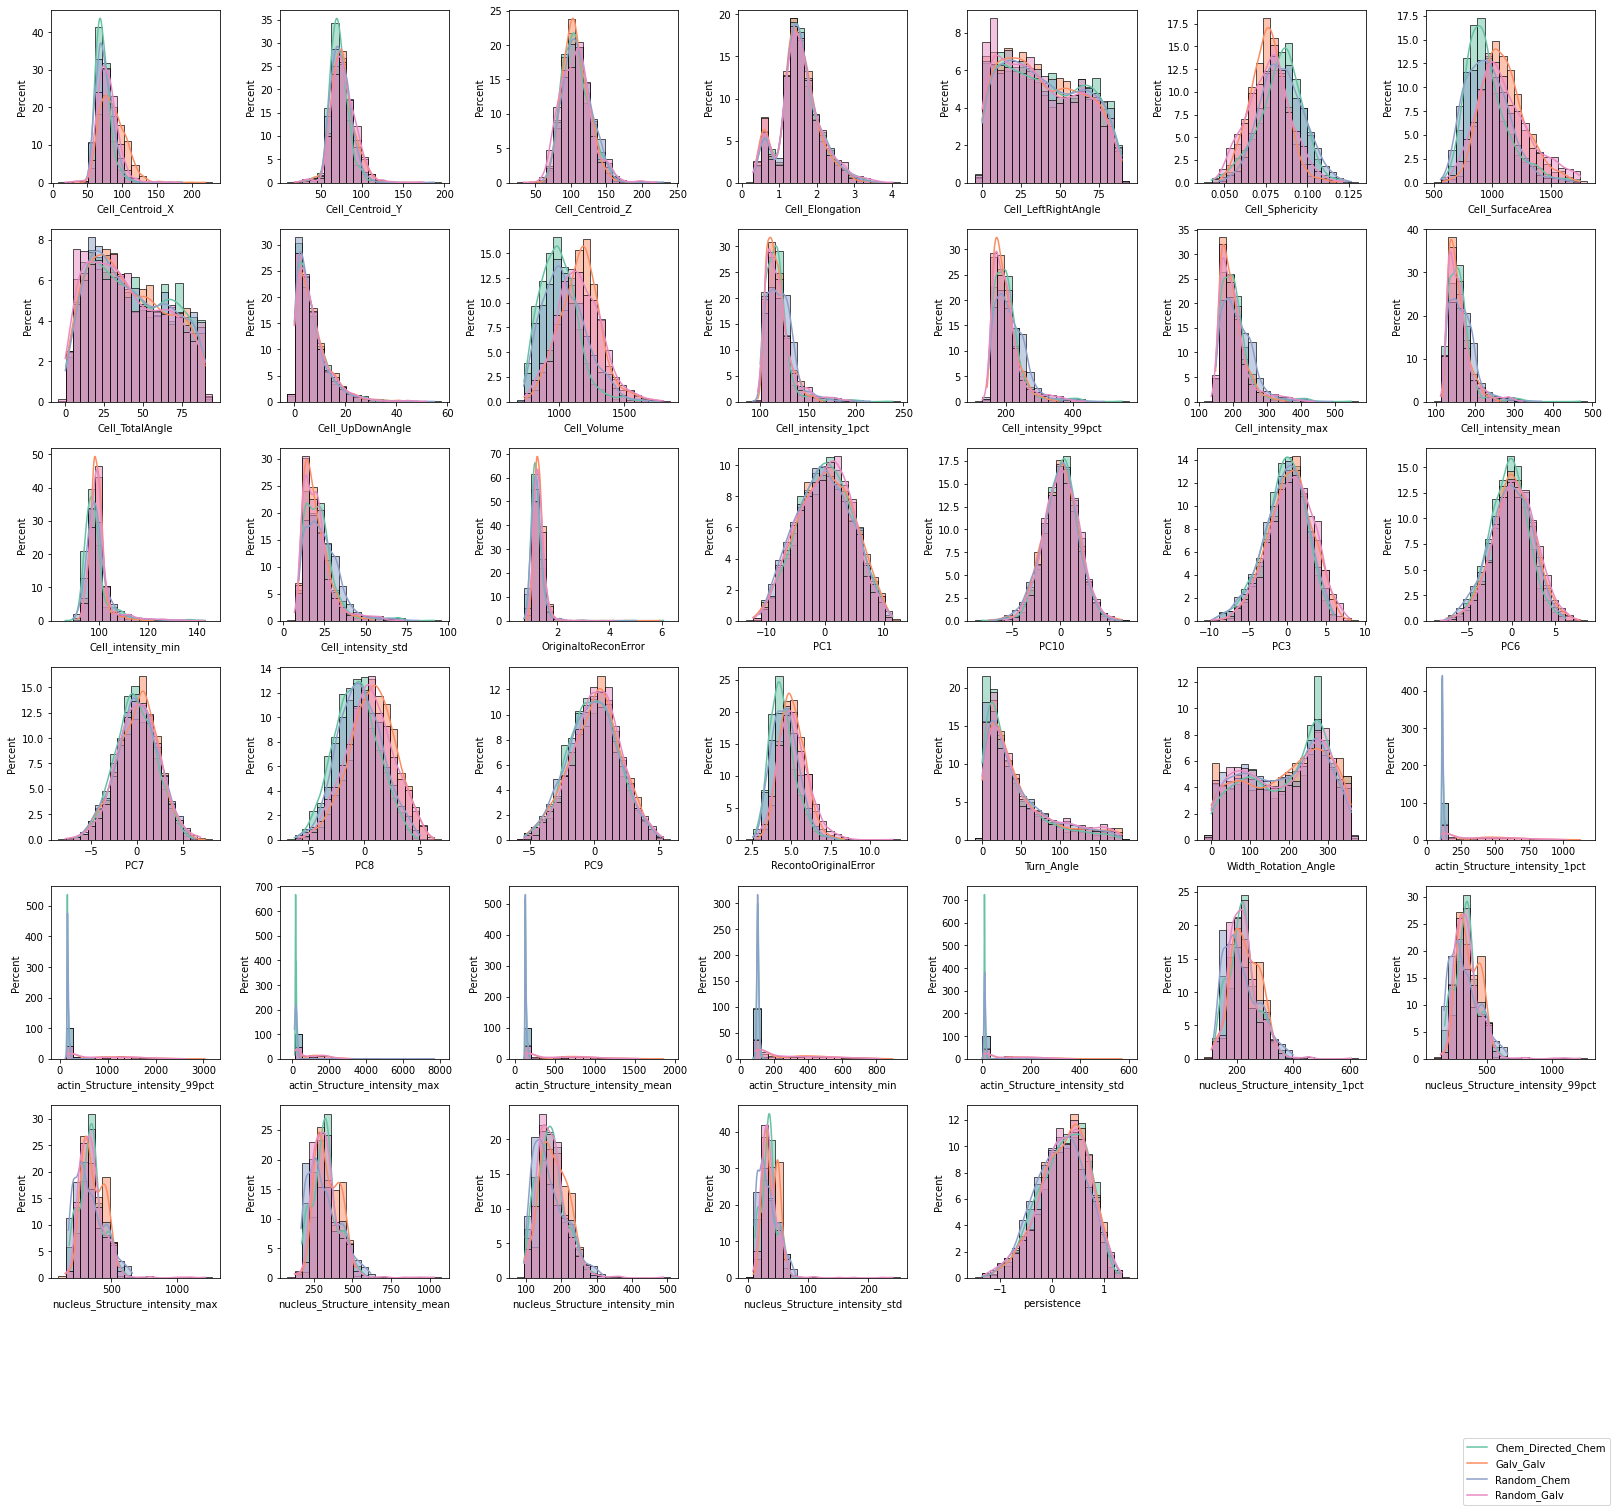

In [68]:
############### get list of metrics that are significant by migration mode using anova ############
ModeFrame = TotalFrame.copy()

import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Migration_Mode' in x])

for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    samples = [g[1].dropna() for g in ModeFrame.groupby(['Migration_Mode','Experiment'])[c]]
    f_val, p_val = ss.f_oneway(*samples)
#     print(f'Name: {c}, F value: {f_val}, p value: {p_val}')
    if p_val < 0.05:
        siglist.append(c) 
siglist = sorted(siglist)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for c in siglist:
    print(f'Name {c}', pairwise_tukeyhsd(ModeFrame[c], 
                                         [one+'_'+two for one, two in zip(ModeFrame['Migration_Mode'].to_list(), ModeFrame['Experiment'].to_list())]))

# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']


################# LOOK AT STAT DISTRIBUTIONS OF SIGNIFICANT STATS ######################
import seaborn as sns

colors = sns.color_palette("Set2")
colors = list(colors.as_hex())


# colors = list(sns.color_palette('deep').as_hex())

CoRo = math.ceil(math.sqrt(len(siglist)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(siglist):

    
    #get the metric in question separated by migration mode
    samples = [g[1].dropna() for g in ModeFrame.groupby(['Migration_Mode','Experiment'])[met]]
    
        
    #get bins so that the widths between all types are the same
    maxx = max([max(x) for x in samples])
    minn = min([min(x) for x in samples])
    binwidth = (maxx-minn)*0.05
    maxx = maxx + binwidth
    minn = minn - binwidth
    binss = np.linspace(minn,maxx,round((maxx-minn)/binwidth))
    
    #plot the data
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    sns.histplot(ax = ax, data=samples[0], bins=binss, stat='percent', color = colors[0], kde = True)
    sns.histplot(ax = ax, data=samples[1], bins=binss, stat='percent', color = colors[1], kde = True)
    sns.histplot(ax = ax, data=samples[2], bins=binss, stat='percent', color = colors[2], kde = True)
    sns.histplot(ax = ax, data=samples[3], bins=binss, stat='percent', color = colors[3], kde = True)
#     ax.set_ylabel(met)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1


ax = axes[row,(i-((CoRo-1)*row)-row)]
fig.legend(['_'.join(g) for g, i in ModeFrame.groupby(['Migration_Mode','Experiment'])], loc = 'lower right')

#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];
# plt.legend(ModeFrame.Migration_Mode.unique(), loc ='lower right')
plt.tight_layout()
# plt.savefig(folder_fl + 'Significant Shape Metric Histograms.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


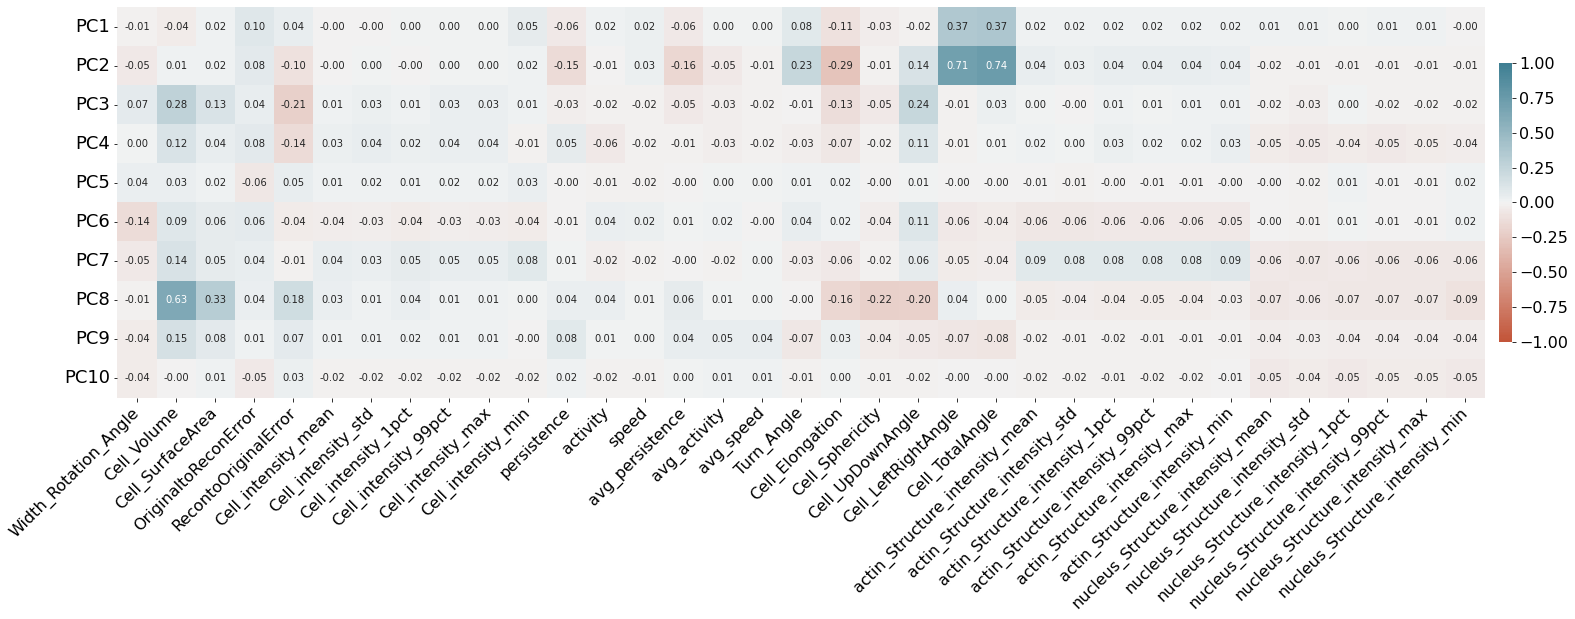

In [28]:
#correlations of shapes with PCs (PCs as rows)

coldrop = []
coldrop.extend([x for x in totalcorr.columns.to_list() if 'delta' in x])
coldrop.extend([x for x in totalcorr.columns.to_list() if 'PC' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend(['frame','dist'])

PCsAndMetrics = totalcorr.loc[[x for x in totalcorr.index if 'PC' in x and 'delta' not in x]]
PCsAndMetrics = PCsAndMetrics.drop(columns = coldrop)
fig, ax = plt.subplots(figsize=(25,15))
ax = sns.heatmap(
    PCsAndMetrics, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    annot = True,
    fmt = '.2f',
    cbar_kws={'fraction':0.01, 'pad':0.01}#, 'shrink': 0.5}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 16
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    va = 'center',
    fontsize = 18
)
#scooch the x axis labels by a certain amount
dx = 6/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)

plt.savefig(folder_fl + 'PC correlation with shape metrics heatmap.png', bbox_inches='tight')

In [19]:
len(PCsAndMetrics.columns)

48

C:\Users\Aaron\anaconda3\envs\shape\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


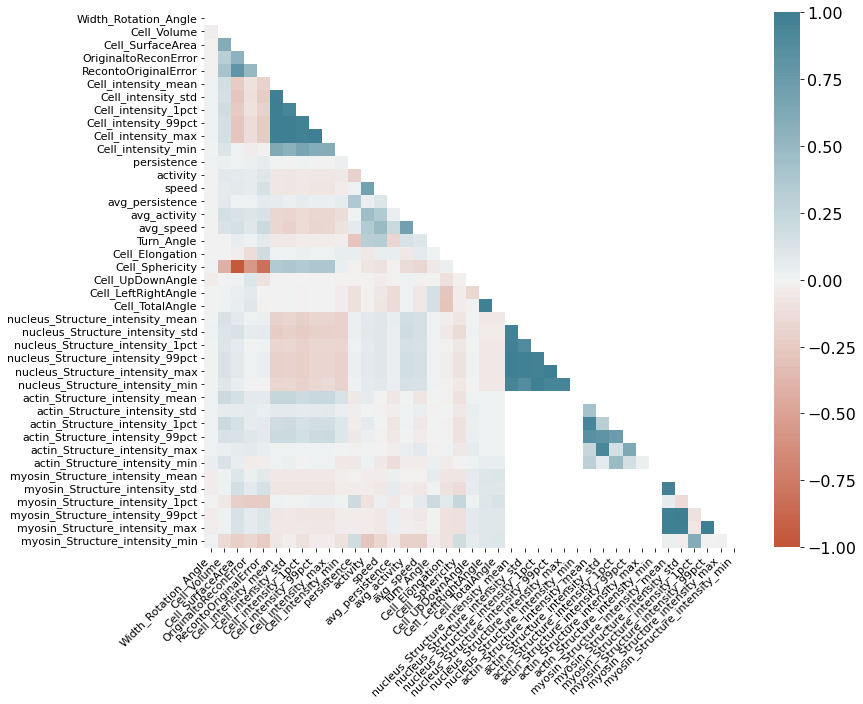

In [28]:
#get columns with nucleus and rows with cells from correlation matrix
coldrop = []
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend(['frame','dist'])

PartFramecorr = TotalFrame.drop(columns = to_remove)
PartFramecorr = PartFramecorr.drop(columns = coldrop)
PartFramecorr = PartFramecorr.drop(columns = ([i for i in PartFramecorr.columns.to_list() if 'PC' in i]))
PartFramecorr = PartFramecorr.drop(columns = ([x for x in PartFramecorr.columns.to_list() if 'delta' in x]))
PartFramecorr = PartFramecorr.corr()

#comparison of CELL features
mask = np.zeros_like(PartFramecorr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(
    PartFramecorr,
    mask = mask,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 11
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize = 11
)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
figsize = (5, 30)
plt.savefig(folder_fl + ' Shape Metric corr.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


NameError: name 'folder_fl' is not defined

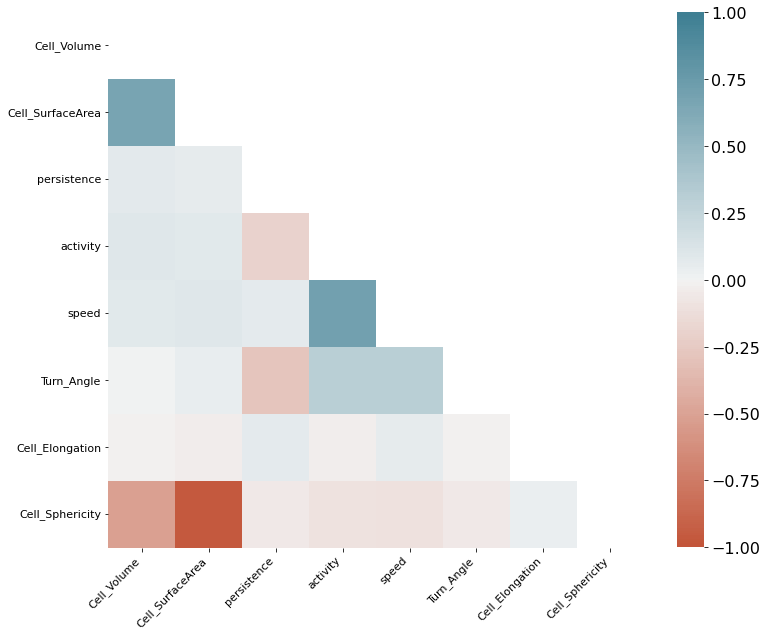

In [6]:
#get columns with nucleus and rows with cells from correlation matrix SMALLER
coldrop = []
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Cell_int' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'actin' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'nucleus' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'myosin' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Error' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'avg' in x])
coldrop.extend(['frame','dist','Cell_UpDownAngle',
                'Cell_LeftRightAngle','Cell_TotalAngle', 'Width_Rotation_Angle',
               'x','y','z'])

PartFramecorr = TotalFrame.drop(columns = to_remove)
PartFramecorr = PartFramecorr.drop(columns = coldrop)
PartFramecorr = PartFramecorr.drop(columns = ([i for i in PartFramecorr.columns.to_list() if 'PC' in i]))
PartFramecorr = PartFramecorr.drop(columns = ([x for x in PartFramecorr.columns.to_list() if 'delta' in x]))
PartFramecorr = PartFramecorr.corr()

#comparison of CELL features
mask = np.zeros_like(PartFramecorr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(
    PartFramecorr,
    mask = mask,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 11
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize = 11
)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
figsize = (5, 30)
plt.savefig(folder_fl + ' Shape Metric corr.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\shape\lib\site-packages\ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator


[Text(1, -1.0, '−1.00'),
 Text(1, -0.75, '−0.75'),
 Text(1, -0.5, '−0.50'),
 Text(1, -0.25, '−0.25'),
 Text(1, 0.0, '0.00'),
 Text(1, 0.25, '0.25'),
 Text(1, 0.5, '0.50'),
 Text(1, 0.75, '0.75'),
 Text(1, 1.0, '1.00')]

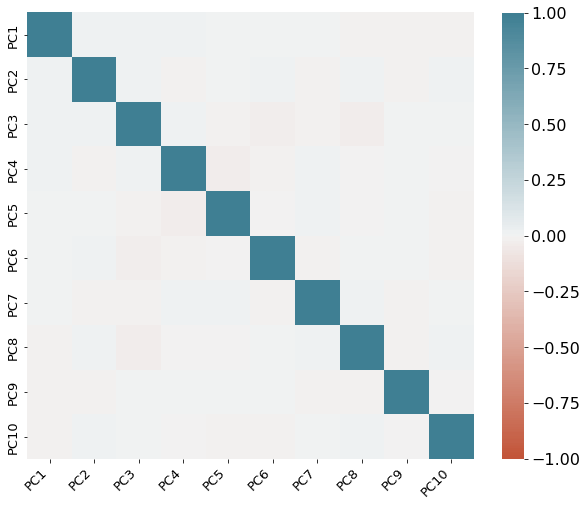

In [29]:
########################## PC Correlations #################

PCcorr = totalcorr.loc[[x for x in list(totalcorr.columns) if 'PC' in x]].loc[:,[x for x in list(totalcorr.columns) if 'PC' in x]]



#comparison of CELL features
fig, ax = plt.subplots(figsize=(len(PCcorr),len(PCcorr)))
ax = sns.heatmap(
    PCcorr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 13
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize = 13
)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)

# plt.savefig(folder_fl + 'Cell+Nuc Shape Metric corr rotationally aligned.png', bbox_inches='tight')

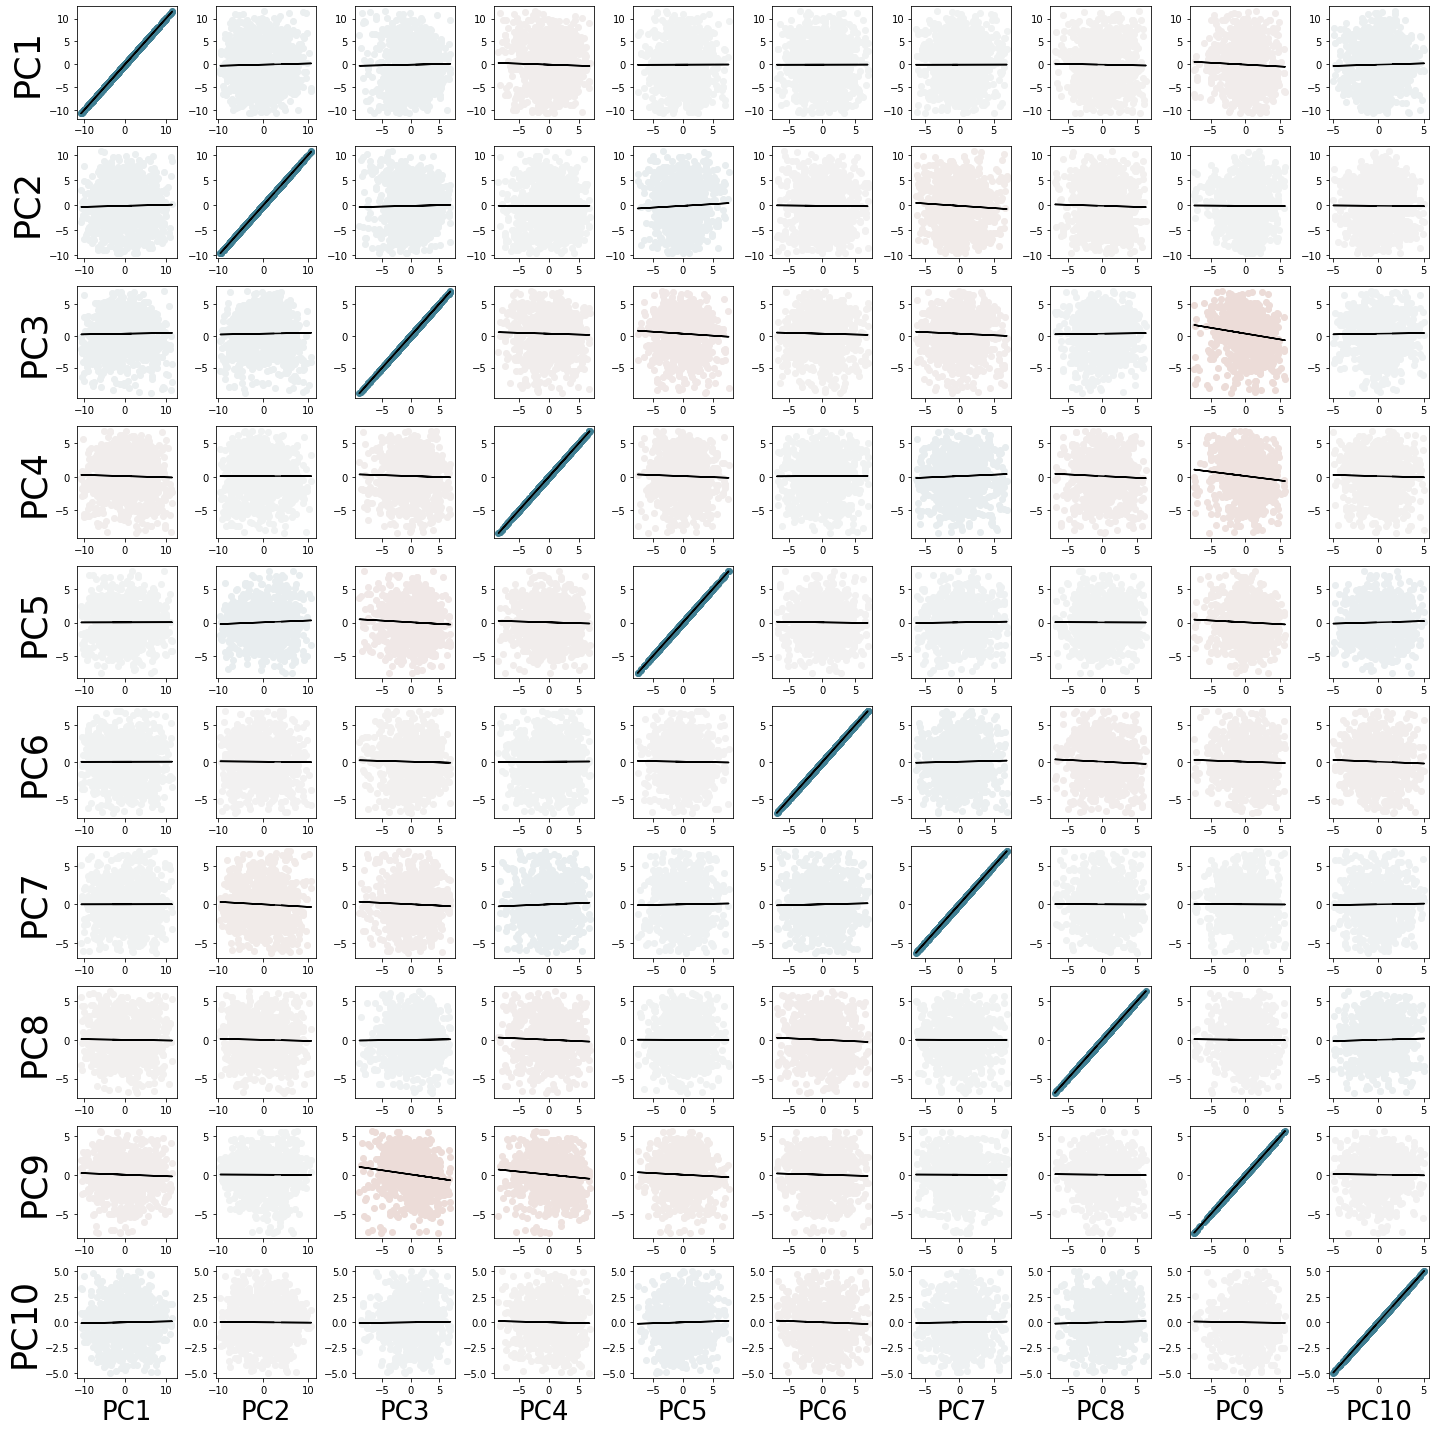

In [15]:
##################### look at scatter correlations between all PCs ###################

def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]

fig, axes = plt.subplots(len(PC_frame.columns), len(PC_frame.columns), figsize=(20,20))#, sharex=True)
for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        x = PC_frame[f'PC{i+1}']
        y = PC_frame[f'PC{q+1}']
        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        p_corr = totalcorr.loc[f'PC{q+1}', f'PC{i+1}']
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, poly1d_fn(x), 'k')




# metric_names = [Shape_Metrics.Cell_Volume.name, 
#                RelativeVectors.Y.name, RelativeVectors.Z.name, 
#                'Y+Z', 
#                RandomRotations.Wide_Variance.name,
#                RelativeAngles.PitchAngle.name,
#                RelativeAngles.RollAngle.name,
#                RelativeAngles.PitchAngleNorm.name,
#               RelativeAngles.RollAngleNorm.name#,
# #                Shape_Metrics.Tilt.name
#                ]

# axes[0,0].set_title("PC 1")
# axes[0,1].set_title("PC 2")
# axes[0,2].set_title("PC 3")
xlabels = PC_frame.columns
[ax.set_ylabel(PC_frame.columns[i], fontsize = 35) for i, ax in enumerate(axes[:,0])];
[ax.set_xlabel(xlabels[i], fontsize = 26) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
# plt.savefig(folder_fl+ 'PC vs. Metric scatter matrix.png', bbox_inches='tight')

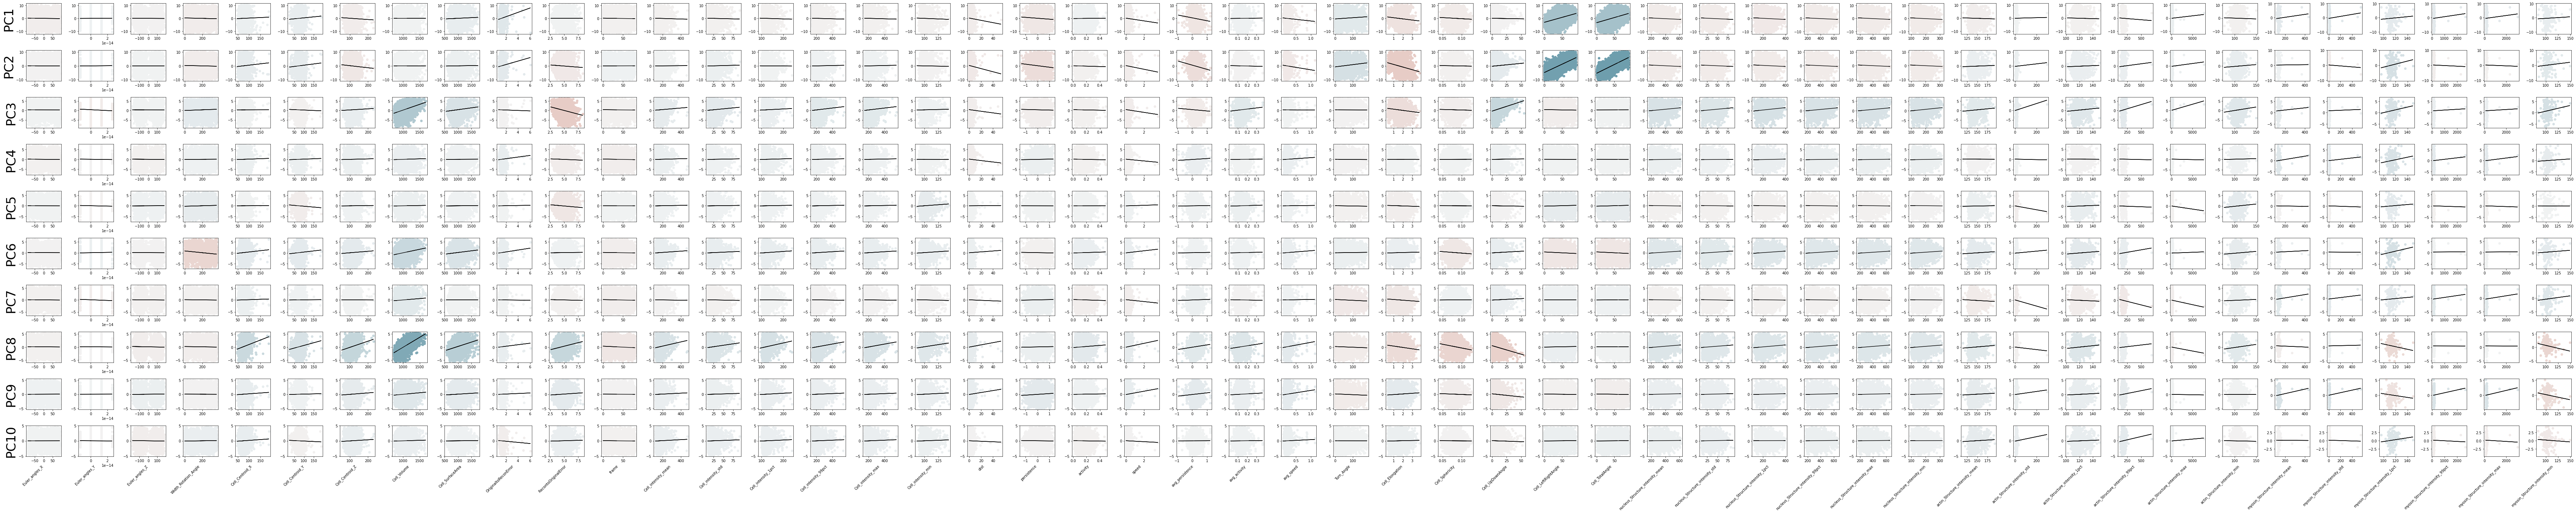

In [8]:
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
#stats to remove, if any
coldrop = [i for i in TotalFrame.columns.to_list() if 'PC' in i] 
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'cell' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'CellID' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'structure' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'Migration' in i])
coldrop.extend(to_remove)
# metric_frame = metric_frame.drop(columns=list(set(metric_frame.columns.to_list()).intersection(to_remove)))
metric_frame = TotalFrame.drop(columns=coldrop)

PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'delta' not in x]]

cols = metric_frame.columns.to_list()
fig, axes = plt.subplots(len(PC_frame.columns), len(metric_frame.columns), figsize=(100,20))#, sharex=True)
for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        rows = metric_frame.iloc[:,i][metric_frame.iloc[:,i].isna() == False].index.to_list()
        x = metric_frame.loc[rows,cols[i]]
        y = PC_frame.loc[rows,f'PC{q+1}']
        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        p_corr = totalcorr.loc[f'PC{q+1}', metric_frame.iloc[:,i].name]
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, poly1d_fn(x), 'k')
#         ax.text(0.1,0.1,str(np.around(p_corr, decimals=2)))



# metric_names = [Shape_Metrics.Cell_Volume.name, 
#                RelativeVectors.Y.name, RelativeVectors.Z.name, 
#                'Y+Z', 
#                RandomRotations.Wide_Variance.name,
#                RelativeAngles.PitchAngle.name,
#                RelativeAngles.RollAngle.name,
#                RelativeAngles.PitchAngleNorm.name,
#               RelativeAngles.RollAngleNorm.name#,
# #                Shape_Metrics.Tilt.name
#                ]

# axes[0,0].set_title("PC 1")
# axes[0,1].set_title("PC 2")
# axes[0,2].set_title("PC 3")
# xlabels = [x.replace('_','\n') for x in metric_frame.columns]
[ax.set_ylabel(PC_frame.columns[i], fontsize = 35) for i, ax in enumerate(axes[:,0])];
[ax.set_xlabel(metric_frame.columns[i], rotation=45, horizontalalignment='right', fontsize = 10) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
plt.savefig(folder_fl+ 'PC vs. Metric scatter matrix.png', bbox_inches='tight')

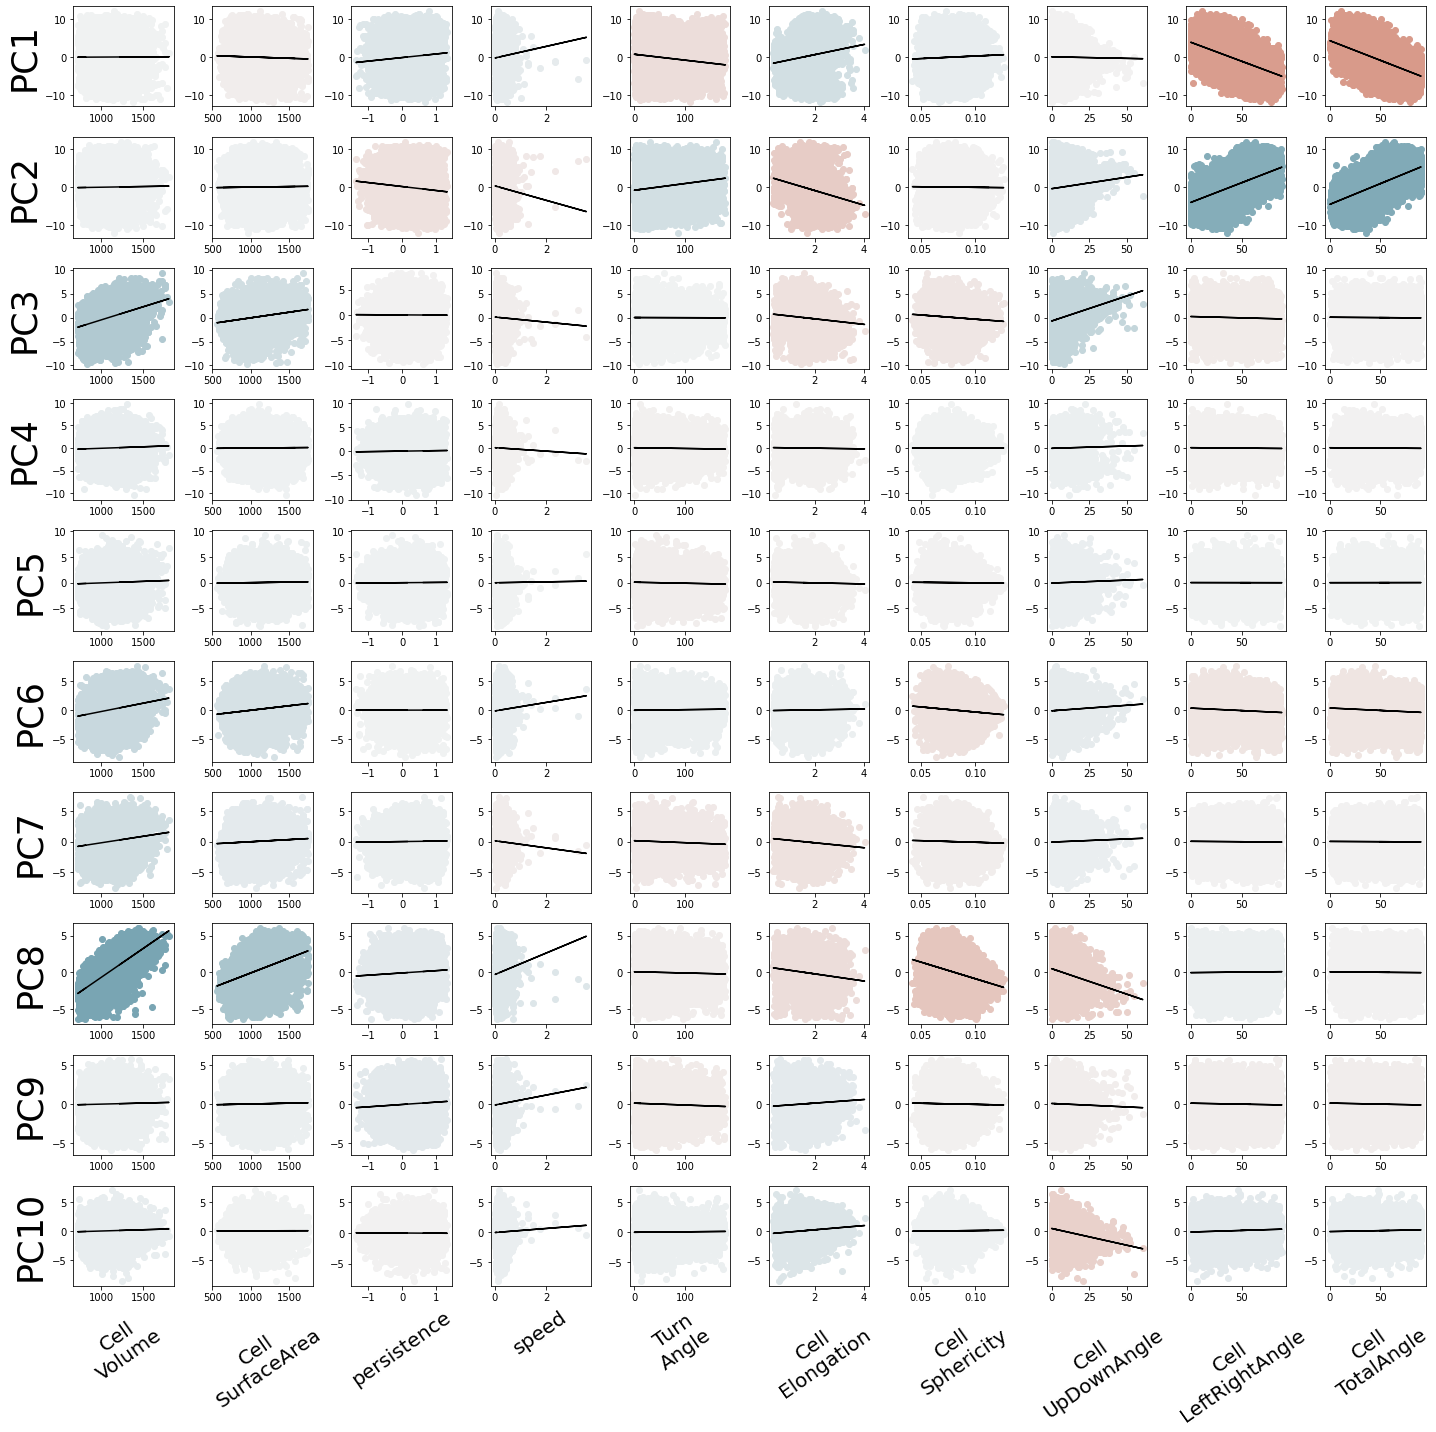

In [114]:
################ smaller PC vs metric plots for CICON ################

def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
#stats to remove, if any
coldrop = [i for i in TotalFrame.columns.to_list() if 'PC' in i] 
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'cell' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'CellID' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'structure' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'Migration' in i])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Cell_int' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'actin' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'nucleus' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'myosin' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Error' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'avg' in x])
coldrop.extend(['frame','dist', 'Experiment','Width_Rotation_Angle','x','y','z','activity'])
coldrop.extend(to_remove)
# metric_frame = metric_frame.drop(columns=list(set(metric_frame.columns.to_list()).intersection(to_remove)))
metric_frame = TotalFrame.drop(columns=coldrop)

PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'delta' not in x]]

cols = metric_frame.columns.to_list()
fig, axes = plt.subplots(len(PC_frame.columns), len(metric_frame.columns), figsize=(20,20))#, sharex=True)
for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        rows = metric_frame.iloc[:,i][metric_frame.iloc[:,i].isna() == False].index.to_list()
        x = metric_frame.loc[rows,cols[i]]
        y = PC_frame.loc[rows,f'PC{q+1}']
        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        p_corr = totalcorr.loc[f'PC{q+1}', metric_frame.iloc[:,i].name]
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, poly1d_fn(x), 'k')
#         ax.text(0.1,0.1,str(np.around(p_corr, decimals=2)))



# metric_names = [Shape_Metrics.Cell_Volume.name, 
#                RelativeVectors.Y.name, RelativeVectors.Z.name, 
#                'Y+Z', 
#                RandomRotations.Wide_Variance.name,
#                RelativeAngles.PitchAngle.name,
#                RelativeAngles.RollAngle.name,
#                RelativeAngles.PitchAngleNorm.name,
#               RelativeAngles.RollAngleNorm.name#,
# #                Shape_Metrics.Tilt.name
#                ]

# axes[0,0].set_title("PC 1")
# axes[0,1].set_title("PC 2")
# axes[0,2].set_title("PC 3")
# xlabels = [x.replace('_','\n') for x in metric_frame.columns]
[ax.set_ylabel(PC_frame.columns[i], fontsize = 35) for i, ax in enumerate(axes[:,0])];
[ax.set_xlabel(metric_frame.columns[i].replace('_','\n'), rotation=35, horizontalalignment='center', fontsize = 20) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
plt.savefig(savedir+ 'PC vs. Metric scatter matrix for CICON.png', bbox_inches='tight')

In [20]:
savedir

'D:/Aaron/Data/Chem_Galv_Combined/'